**Exercise:**

The "carprices.csv" file lists car selling prices for three different models. First, plot the data points on a scatter plot chart to determine if a linear regression model can be applied. If it can, proceed to build a model that can answer the following questions:

* Predict the price of a Mercedes-Benz that is 4 years old with mileage 45,000.

* Predict the price of a BMW X5 that is 7 years old with mileage 86,000.

* Provide the score (accuracy) of your model. (Hint: use LinearRegression().score())

In [2]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor

# Enable inline plotting for Jupyter notebooks.
%matplotlib inline

In [3]:
# Load the dataset.
df = pd.read_csv('carprices.csv')

# Display the first 5 rows of the dataframe.
df.head()

,Car Model,Mileage,Sell Price($),Age(yrs)
0,BMW X5,69000,18000,6
1,BMW X5,35000,34000,3
2,BMW X5,57000,26100,5
3,BMW X5,22500,40000,2
4,BMW X5,46000,31500,4


In [4]:
# Get the shape of the dataset.
num_rows, num_columns = df.shape

# Format the output and print it.
output = (
    f"Dataset Overview\n"
    f"{'-'*30}\n"
    f"Number of Rows    : {num_rows}\n"
    f"Number of Columns : {num_columns}\n"
    f"{'-'*30}"
)

print(output)

Dataset Overview
------------------------------
Number of Rows    : 13
Number of Columns : 4
------------------------------


## Data Preprocessing:

In [6]:
# Obtain a list of all of the categorical variables in the training dataset.
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

# Print the list of categorical variables.
print(f"Categorical variables in the training dataset ({len(object_cols)}):")
print(object_cols)

Categorical variables in the training dataset (1):
['Car Model']


In [7]:
# Print all unique values in the categorical columns of the training dataset.
for col in object_cols:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}' column:")
    print(unique_values)
    print("\n")

# Identify and count number of unique entries in each categorical column of the training dataset.
object_nunique = [df[col].nunique() for col in object_cols]

# Create a dictionary mapping each categorical column to its number of unique entries.
unique_counts_dict = dict(zip(object_cols, object_nunique))

# Sort the dictionary items by number of unique entries in ascending order.
sorted_unique_counts = sorted(unique_counts_dict.items(), key=lambda x: x[1])

# Print the sorted results.
print("Number of unique entries in each categorical column of training dataset, sorted in ascending order:")
for col, count in sorted_unique_counts:
    print(f"{col}: {count}")

Unique values in 'Car Model' column:
['BMW X5' 'Audi A5' 'Mercedez Benz C class']


Number of unique entries in each categorical column of training dataset, sorted in ascending order:
Car Model: 3


In [8]:
# Initialize OneHotEncoder.
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply one-hot encoding to the categorical columns.
# Use get_feature_names_out() to get the column names for the encoded data.
one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[object_cols]), columns=one_hot_encoder.get_feature_names_out(object_cols))

# One-hot encoding removed index; put it back.
one_hot_encoded.index = df.index

# Remove categorical columns from original datasets to get numerical columns only.
numerical_df = df.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features.
df_encoded = pd.concat([numerical_df, one_hot_encoded], axis=1)

# Remove one encoded column from each category to take care of the dummy variable trap, ensuring the encoded data does not suffer from multi-collinearity.
for category in object_cols:
    category_encoded_columns = [col for col in df_encoded.columns if col.startswith(f'{category}_')]
    if category_encoded_columns:
        df_encoded.drop(columns=category_encoded_columns[0], inplace=True)

# Ensure all columns have string type.
df_encoded.columns = df_encoded.columns.astype(str)

# Display the dataframe after preprocessing.
df_encoded

,Mileage,Sell Price($),Age(yrs),Car Model_BMW X5,Car Model_Mercedez Benz C class
0,69000,18000,6,1.0,0.0
1,35000,34000,3,1.0,0.0
2,57000,26100,5,1.0,0.0
3,22500,40000,2,1.0,0.0
4,46000,31500,4,1.0,0.0
5,59000,29400,5,0.0,0.0
6,52000,32000,5,0.0,0.0
7,72000,19300,6,0.0,0.0
8,91000,12000,8,0.0,0.0
9,67000,22000,6,0.0,1.0


## Data Exploration and Visualization:

In [10]:
# Display a summary of statistics for each column in the dataframe.
# This includes count, mean, std deviation, min, 25%, 50%, 75%, and max values.
df_encoded.describe()

,Mileage,Sell Price($),Age(yrs),Car Model_BMW X5,Car Model_Mercedez Benz C class
count,13.000000,13.000000,13.000000,13.000000,13.000000
mean,60884.615385,26023.076923,5.307692,0.384615,0.307692
std,19185.665055,8003.661021,1.652504,0.506370,0.480384
min,22500.000000,12000.000000,2.000000,0.000000,0.000000
25%,52000.000000,20000.000000,5.000000,0.000000,0.000000
50%,59000.000000,26100.000000,5.000000,0.000000,0.000000
75%,72000.000000,32000.000000,6.000000,1.000000,1.000000
max,91000.000000,40000.000000,8.000000,1.000000,1.000000


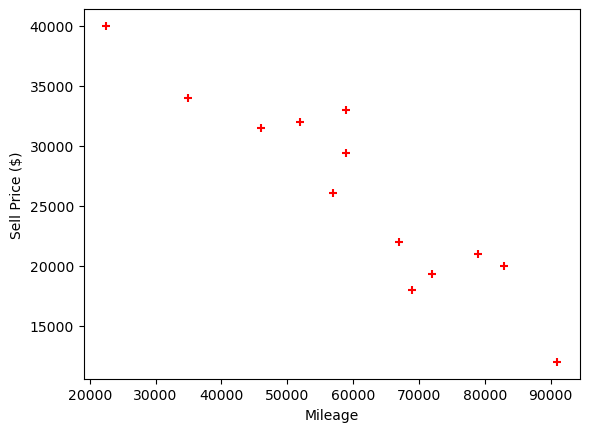

In [11]:
# Plot the data points.
plt.xlabel('Mileage')
plt.ylabel('Sell Price ($)')
plt.scatter(df_encoded['Mileage'], df_encoded['Sell Price($)'], color='red', marker='+')
plt.show()

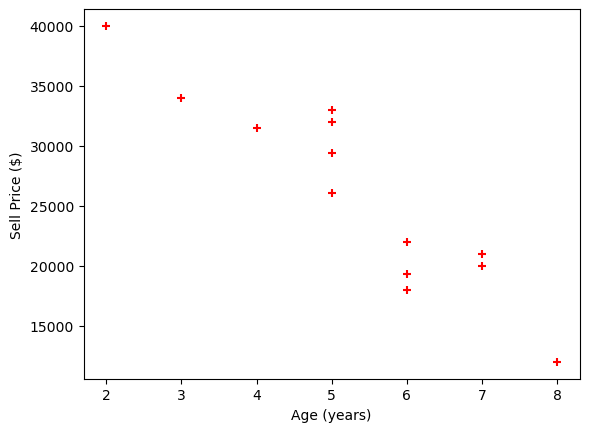

In [12]:
# Plot the data points.
plt.xlabel('Age (years)')
plt.ylabel('Sell Price ($)')
plt.scatter(df_encoded['Age(yrs)'], df_encoded['Sell Price($)'], color='red', marker='+')
plt.show()

## Model Training and Prediction:

In [14]:
# Prepare the data for training.
X = df_encoded.drop('Sell Price($)', axis='columns') # Features (independent variable)
y = df_encoded['Sell Price($)']                      # Target   (dependent variable)

# Display the first 5 rows of features.
X.head()

,Mileage,Age(yrs),Car Model_BMW X5,Car Model_Mercedez Benz C class
0,69000,6,1.0,0.0
1,35000,3,1.0,0.0
2,57000,5,1.0,0.0
3,22500,2,1.0,0.0
4,46000,4,1.0,0.0


In [15]:
# Display the first 5 rows of the target variable.
y.head()

0    18000
1    34000
2    26100
3    40000
4    31500
Name: Sell Price($), dtype: int64

In [16]:
# Split the dataset into training and testing sets.
# X_train: Training set features.
# X_test: Testing set features.
# y_train: Training set target variable.
# y_test: Testing set target variable.
# test_size=0.2: 20% of the data will be used for testing, 80% for training.
# stratify=y: Ensures the target variable 'y' is evenly distributed in both training and testing sets. It should be used in case of an imbalanced dataset.
# random_state=42: Ensures reproducibility of the split.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=None, random_state=42)

# Print the number of samples in training and testing sets.
print(f"{'Training set size':<20}: {len(X_train)} samples")
print(f"{'Testing set size':<20}: {len(X_test)} samples")

Training set size   : 10 samples
Testing set size    : 3 samples


In [17]:
# Create an instance of StandardScaler.
scaler = StandardScaler()

# Fit the scaler on the training data and transform it.
# This computes the mean and standard deviation on X_train and then scales X_train accordingly.
X_train_scaled_array = scaler.fit_transform(X_train)

# Use the previously computed mean and standard deviation to scale the test data.
X_test_scaled_array = scaler.transform(X_test)

# Convert the scaled arrays back to dataframes.
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)

### 1) Linear Regression

In [19]:
# Instantiate and train the linear regression model.
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

LinearRegression()

In [20]:
# Output the coefficients (slope) and intercept of the trained model's prediction function.
print(f"Coefficients (slope or gradient): {reg.coef_}")
print(f"Intercept: {reg.intercept_}")

Coefficients (slope or gradient): [-14229.75644708   4823.26194105  -1746.21656933   2052.31102992]
Intercept: 27730.0


In [21]:
# Compute and print the training score of the trained model.
train_score = reg.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = reg.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 0.977
The testing score is: -6.263


In [22]:
# Initialize KFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score with different scoring metrics.
cv_scores_mae = cross_val_score(reg, X_train_scaled, y_train, cv=kf, scoring='neg_mean_absolute_error')
cv_scores_mse = cross_val_score(reg, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_scores_rmse = cross_val_score(reg, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Print the average cross-validation MAE, MSE, and RMSE.
print(f"The linear regression model's average cross-validation MAE using KFold: {-np.mean(cv_scores_mae):.3f}")
print(f"The linear regression model's average cross-validation MSE using KFold: {-np.mean(cv_scores_mse):.3f}")
print(f"The linear regression model's average cross-validation RMSE using KFold: {-np.mean(cv_scores_rmse):.3f}")

The linear regression model's average cross-validation MAE using KFold: 2131.467
The linear regression model's average cross-validation MSE using KFold: 5094846.710
The linear regression model's average cross-validation RMSE using KFold: 2131.467


In [23]:
# Define the feature names based on the training data.
feature_names = ['Mileage', 'Age(yrs)', 'Car Model_BMW X5', 'Car Model_Mercedez Benz C class']

# Predict the price of a Mercedes-Benz that is 4 years old with mileage 45,000.
# Convert the input to a DataFrame with the appropriate column name.
predicted_price = reg.predict(pd.DataFrame([[45000, 4, 0, 1]], columns=feature_names))
print(f"Predicted price for a Mercedes-Benz that is 4 years old with mileage 45,000: $ {predicted_price[0]:,.2f}")

# Predict the price of a BMW X5 that is 7 years old with mileage 86,000.
# Convert the input to a DataFrame with the appropriate column name.
predicted_price = reg.predict(pd.DataFrame([[86000, 7, 1, 0]], columns=feature_names))
print(f"Predicted price for a BMW X5 that is 7 years old with mileage 86,000: $ {predicted_price[0]:,.2f}")

Predicted price for a Mercedes-Benz that is 4 years old with mileage 45,000: $ -640,289,964.76
Predicted price for a BMW X5 that is 7 years old with mileage 86,000: $ -1,223,699,307.83


### 2) Lasso (L1 Regularized) Regression

In [25]:
# Instantiate and train the lasso regression model.
lasso_reg = Lasso(max_iter=10000)
lasso_reg.fit(X_train_scaled, y_train)

Lasso(max_iter=10000)

In [26]:
# Output the coefficients (slope) and intercept of the trained model's prediction function.
print(f"Coefficients (slope or gradient): {lasso_reg.coef_}")
print(f"Intercept: {lasso_reg.intercept_}")

Coefficients (slope or gradient): [-14034.45483422   4628.40216596  -1750.32373192   2041.68631673]
Intercept: 27730.0


In [27]:
# Compute and print the training score of the trained model.
train_score = lasso_reg.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = lasso_reg.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 0.977
The testing score is: -6.167


In [28]:
# Initialize KFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score with different scoring metrics.
cv_scores_mae = cross_val_score(lasso_reg, X_train_scaled, y_train, cv=kf, scoring='neg_mean_absolute_error')
cv_scores_mse = cross_val_score(lasso_reg, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_scores_rmse = cross_val_score(lasso_reg, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Print the average cross-validation MAE, MSE, and RMSE.
print(f"The lasso regression model's average cross-validation MAE using KFold: {-np.mean(cv_scores_mae):.3f}")
print(f"The lasso regression model's average cross-validation MSE using KFold: {-np.mean(cv_scores_mse):.3f}")
print(f"The lasso regression model's average cross-validation RMSE using KFold: {-np.mean(cv_scores_rmse):.3f}")

The lasso regression model's average cross-validation MAE using KFold: 2096.873
The lasso regression model's average cross-validation MSE using KFold: 4978586.029
The lasso regression model's average cross-validation RMSE using KFold: 2096.873


In [29]:
# Define the feature names based on the training data.
feature_names = ['Mileage', 'Age(yrs)', 'Car Model_BMW X5', 'Car Model_Mercedez Benz C class']

# Predict the price of a Mercedes-Benz that is 4 years old with mileage 45,000.
# Convert the input to a DataFrame with the appropriate column name.
predicted_price = lasso_reg.predict(pd.DataFrame([[45000, 4, 0, 1]], columns=feature_names))
print(f"Predicted price for a Mercedes-Benz that is 4 years old with mileage 45,000: $ {predicted_price[0]:,.2f}")

# Predict the price of a BMW X5 that is 7 years old with mileage 86,000.
# Convert the input to a DataFrame with the appropriate column name.
predicted_price = lasso_reg.predict(pd.DataFrame([[86000, 7, 1, 0]], columns=feature_names))
print(f"Predicted price for a BMW X5 that is 7 years old with mileage 86,000: $ {predicted_price[0]:,.2f}")

Predicted price for a Mercedes-Benz that is 4 years old with mileage 45,000: $ -631,502,182.24
Predicted price for a BMW X5 that is 7 years old with mileage 86,000: $ -1,206,904,737.25


### 3) Ridge (L2 Regularized) Regression

In [31]:
# Instantiate and train the ridge regression model.
ridge_reg = Ridge()
ridge_reg.fit(X_train_scaled, y_train)

Ridge()

In [32]:
# Output the coefficients (slope) and intercept of the trained model's prediction function.
print(f"Coefficients (slope or gradient): {ridge_reg.coef_}")
print(f"Intercept: {ridge_reg.intercept_}")

Coefficients (slope or gradient): [-4672.24715715 -3702.0030142  -1172.50372521  1450.54178929]
Intercept: 27730.0


In [33]:
# Compute and print the training score of the trained model.
train_score = ridge_reg.score(X_train_scaled, y_train)
print(f"The training score is: {train_score:.3f}")

# Compute and print the testing score of the trained model.
test_score = ridge_reg.score(X_test_scaled, y_test)
print(f"The testing score is: {test_score:.3f}")

The training score is: 0.954
The testing score is: -3.029


In [34]:
# Initialize KFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation using cross_val_score with different scoring metrics.
cv_scores_mae = cross_val_score(ridge_reg, X_train_scaled, y_train, cv=kf, scoring='neg_mean_absolute_error')
cv_scores_mse = cross_val_score(ridge_reg, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_scores_rmse = cross_val_score(ridge_reg, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Print the average cross-validation MAE, MSE, and RMSE.
print(f"The ridge regression model's average cross-validation MAE using KFold: {-np.mean(cv_scores_mae):.3f}")
print(f"The ridge regression model's average cross-validation MSE using KFold: {-np.mean(cv_scores_mse):.3f}")
print(f"The ridge regression model's average cross-validation RMSE using KFold: {-np.mean(cv_scores_rmse):.3f}")

The ridge regression model's average cross-validation MAE using KFold: 2408.437
The ridge regression model's average cross-validation MSE using KFold: 7230052.831
The ridge regression model's average cross-validation RMSE using KFold: 2408.437


In [35]:
# Define the feature names based on the training data.
feature_names = ['Mileage', 'Age(yrs)', 'Car Model_BMW X5', 'Car Model_Mercedez Benz C class']

# Predict the price of a Mercedes-Benz that is 4 years old with mileage 45,000.
# Convert the input to a DataFrame with the appropriate column name.
predicted_price = ridge_reg.predict(pd.DataFrame([[45000, 4, 0, 1]], columns=feature_names))
print(f"Predicted price for a Mercedes-Benz that is 4 years old with mileage 45,000: $ {predicted_price[0]:,.2f}")

# Predict the price of a BMW X5 that is 7 years old with mileage 86,000.
# Convert the input to a DataFrame with the appropriate column name.
predicted_price = ridge_reg.predict(pd.DataFrame([[86000, 7, 1, 0]], columns=feature_names))
print(f"Predicted price for a BMW X5 that is 7 years old with mileage 86,000: $ {predicted_price[0]:,.2f}")

Predicted price for a Mercedes-Benz that is 4 years old with mileage 45,000: $ -210,236,749.54
Predicted price for a BMW X5 that is 7 years old with mileage 86,000: $ -401,812,612.04


### 4) Bagging Regressor

In [37]:
# Define the base estimators.
base_estimators = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(max_iter=500000),
    "Ridge Regression": Ridge()
}

# Apply BaggingRegressor to each base estimator.
for name, estimator in base_estimators.items():
    print(f"\nModel: {name}\n{'-'*30}")

    # Create a BaggingRegressor.
    bagging_model = BaggingRegressor(
        estimator=estimator,       # Base estimator (different models).
        n_estimators=100,          # Number of base estimators in the ensemble.
        max_samples=0.8,           # Fraction of samples to draw from X to train each base estimator.
        oob_score=True,            # Use out-of-bag samples to estimate the generalization error.
        random_state=42            # Seed for reproducibility.
    )

    # Fit the BaggingRegressor to the training data.
    bagging_model.fit(X_train_scaled, y_train)

    # Compute and print the out-of-bag score of the trained model.
    oob_score = bagging_model.oob_score_
    print(f"Out-of-Bag score is: {oob_score:.3f}")

    # Compute and print the testing score of the trained model.
    test_score = bagging_model.score(X_test_scaled, y_test)
    print(f"The testing score is: {test_score:.3f}")


Model: Linear Regression
------------------------------
Out-of-Bag score is: 0.863
The testing score is: -8.955

Model: Lasso Regression
------------------------------
Out-of-Bag score is: 0.898
The testing score is: -7.558

Model: Ridge Regression
------------------------------
Out-of-Bag score is: 0.824
The testing score is: -3.479


In [38]:
# Define the base estimators.
base_estimators = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(max_iter=500000),
    "Ridge Regression": Ridge()
}

# Initialize KFold and split the dataset into n_splits equal parts by shuffling the data before splitting into folds to ensure random distribution of samples.
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Apply cross-validation to each base estimator.
for name, estimator in base_estimators.items():
    print(f"\nModel: {name}\n{'-'*30}")

    # Create a BaggingRegressor for the current base estimator.
    bagging_model = BaggingRegressor(
        estimator=estimator,        # Base estimator (different models).
        n_estimators=100,           # Number of base estimators in the ensemble.
        max_samples=0.8,            # Fraction of samples to draw from X to train each base estimator.
        random_state=42             # Seed for reproducibility.
    )

    # Perform cross-validation using cross_val_score with different scoring metrics.
    cv_scores_mae = cross_val_score(bagging_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_absolute_error')
    cv_scores_mse = cross_val_score(bagging_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_scores_rmse = cross_val_score(bagging_model, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')

    # Print the average cross-validation MAE, MSE, and RMSE.
    print(f"Average cross-validation MAE using KFold: {-np.mean(cv_scores_mae):.3f}")
    print(f"Average cross-validation MSE using KFold: {-np.mean(cv_scores_mse):.3f}")
    print(f"Average cross-validation RMSE using KFold: {-np.mean(cv_scores_rmse):.3f}")


Model: Linear Regression
------------------------------
Average cross-validation MAE using KFold: 2334.023
Average cross-validation MSE using KFold: 7514808.021
Average cross-validation RMSE using KFold: 2334.023

Model: Lasso Regression
------------------------------
Average cross-validation MAE using KFold: 2272.384
Average cross-validation MSE using KFold: 6625909.944
Average cross-validation RMSE using KFold: 2272.384

Model: Ridge Regression
------------------------------
Average cross-validation MAE using KFold: 2758.971
Average cross-validation MSE using KFold: 11707862.864
Average cross-validation RMSE using KFold: 2758.971


## Saving Trained Model using joblib:

In [40]:
# import joblib

# # Serialize the trained model using joblib.
# model_filename = 'model_linear_regression_with_multiple_variables_2.pkl'
# try:
#     joblib.dump(reg, model_filename)
#     print(f"Trained model saved successfully as '{model_filename}'")
# except Exception as e:
#     print(f"Failed to save model: {e}")

In [41]:
# # Load the saved model back.
# try:
#     loaded_model = joblib.load(model_filename)
#     # Use 'loaded_model' for predictions or further analysis.
# except Exception as e:
#     print(f"Failed to load model: {e}")